In [205]:
using Turing, Distributions


# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
# using MLDataUtils: shuffleobs, stratifiedobs, rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

using StatsBase
using DataFrames
import CSV
import MLJBase
using MLJ
include("pred_funcs.jl")
# setprogress!(true)

transform_normalizer! (generic function with 1 method)

In [206]:
MissingImputator = @load MissingImputator pkg="BetaML"

import BetaML ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


BetaML.Clustering.MissingImputator

In [212]:
iris = CSV.read("iris.csv",DataFrame,stringtype=String)
filter!(x->x.class != "Iris-virginica",iris)

MLJBase.coerce!(iris,:class=>MLJBase.OrderedFactor)
iris.class = [i=="Iris-setosa" ? true : false for i in iris.class]
y,x=MLJBase.unpack(iris,
    ==(:class),colname -> true );

# x = DataFrames.select(iris, DataFrames.Not(:class))
# y = iris.class
# y = [i=="Iris-setosa" ? true : false for i in y]

In [213]:
train, test = MLJBase.partition(eachindex(y), 0.02, stratify=y,  shuffle=true)

┌ Warning: Some splits have a single or no representative of some class.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/data/data.jl:63


([55, 39], [79, 10, 57, 82, 2, 7, 60, 25, 13, 19  …  50, 69, 94, 42, 35, 27, 59, 31, 53, 1])

In [214]:
allowmissing!(x);

In [215]:
perc_missing = 0.10
nn=round(Int,perc_missing*400); # create abritrary missing
yrand = rand(1:ncol(x),nn);
xrand = rand(1:nrow(x),nn);

In [216]:

xnew = copy(x)
for i in 1:nn
    xnew[xrand[i],yrand[i]] = missing
end
stmach = machine(MissingImputator(K=3),xnew[train,:]) 
sttran = fit!(stmach,verbosity=0)
tt = MLJ.transform(sttran,xnew)
for i in 1:ncol(xnew)
    xnew[:,i] = tt[i]
end
println(sum(Matrix(abs.(xnew.-x)))/nn)
disallowmissing!(xnew)
transform_standardizer!(xnew,fit_standardizer(xnew))


0.2765362880002399


In [217]:
@model function logistic_regression(x, y, n, σ)
    intercept ~ Normal(0, σ)

    sepal_length ~ Normal(0, σ)
    sepal_width  ~ Normal(0, σ)
    petal_length ~ Normal(0, σ)
    petal_width  ~ Normal(0, σ)

    for i = 1:n
        v = logistic(intercept + sepal_length*x[i, 1] + sepal_width*x[i,2] + petal_length*x[i,3] + petal_width*x[i,4] )
        y[i] ~ Bernoulli(v)
    end
end;

In [218]:
n = length(y[train])
println(n)
# Sample using HMC.
m = logistic_regression(xnew[train,:], y[train], n, 1)
chain = sample(m, HMC(0.05, 100), MCMCThreads(), 1000, 3)

describe(chain)

2


Sampling (3 threads): 100%|█████████████████████████████| Time: 0:00:00


2-element Vector{ChainDataFrame}:
 Summary Statistics (5 x 8)
 Quantiles (5 x 6)

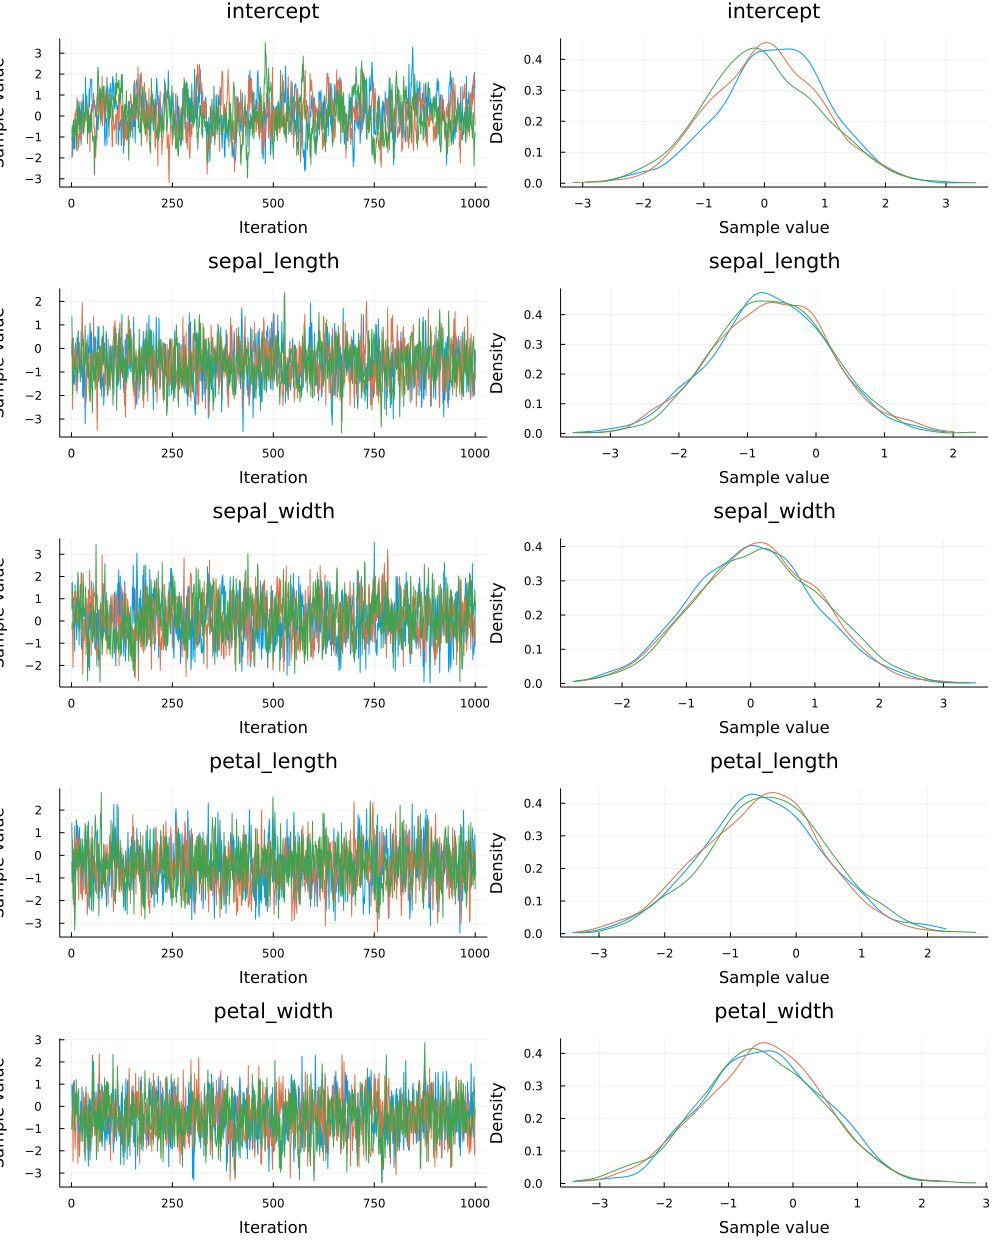

In [219]:
plot(chain)

In [220]:
function prediction(x, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    sepal_length = mean(chain[:sepal_length])
    sepal_width = mean(chain[:sepal_width])
    petal_length = mean(chain[:petal_length])
    petal_width = mean(chain[:petal_width])

    # Retrieve the number of rows.
    n = nrow(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        v[i] = logistic(intercept + sepal_length*x[i, 1] + sepal_width*x[i,2] + petal_length*x[i,3] + petal_width*x[i,4] )
    end
    return v
end;

In [221]:
ypred = prediction(xnew[test,:],chain);

In [187]:
yhat = [i>.5 ? true : false for i in ypred];

In [188]:
y[test];

In [189]:
MLJ.ConfusionMatrix()(yhat,y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='false' and positive='true'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/measures/confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │     47      │      0      │
├─────────────┼─────────────┼─────────────┤
│    true     │      2      │     49      │
└─────────────┴─────────────┴─────────────┘


In [202]:
@model function GaussianMixtureModel(x)

    D,N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()

    # Draw the parameters for cluster 2.
    μ2 ~ Normal()

    μ = [μ1, μ2]

    # Uncomment the following lines to draw the weights for the K clusters
    # from a Dirichlet distribution.

    # α = 1.0
    # w ~ Dirichlet(2, α)

    # Comment out this line if you instead want to draw the weights.
    w = [0.5, 0.5]

    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], μ[k[i]], 1.)
    end
    return k
end;

In [203]:
gmm_model = GaussianMixtureModel(Matrix(Matrix(xnew[:,1:3])' ) );

In [204]:
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))
tchain = sample(gmm_model, gmm_sampler, 100);

LoadError: MethodError: no method matching MvNormal(::Vector{Float64}, ::Float64, ::Float64)
[0mClosest candidates are:
[0m  MvNormal(::AbstractVector{var"#s472"} where var"#s472"<:Real, ::Real) at deprecated.jl:70
[0m  MvNormal([91m::Tracker.TrackedVector{var"#s54", A} where {var"#s54"<:Real, A}[39m, ::Real) at /Users/alexpanchot/.julia/packages/DistributionsAD/b93cZ/src/tracker.jl:462
[0m  MvNormal(::AbstractVector{var"#s472"} where var"#s472"<:Real) at deprecated.jl:70
[0m  ...

In [198]:
tchain = tchain[:, :, 1]

Chains MCMC chain (100×5×1 Array{Float64, 3}):

Iterations        = 1:1:100
Number of chains  = 1
Samples per chain = 100
Wall duration     = 10.58 seconds
Compute duration  = 10.58 seconds
parameters        = μ1, μ2, k[1], k[2]
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          μ1    0.0608    0.9031     0.0903    0.2205   14.1771    1.0111      ⋯
          μ2   -0.1971    0.5751     0.0575    0.1349   13.7437    1.0040      ⋯
        k[1]    1.5700    0.4976     0.0498    0.0920   25.1170    1.0401      ⋯
        k[2]    1.5400    0.5009     0.0501    0.0806   31.3484    1.0044      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          μ1   -2.18

In [199]:
assignments = mean(MCMCChains.group(tchain, :k)).nt.mean

2-element Vector{Float64}:
 1.57
 1.54